In [485]:
import numpy as np
import arch
import scipy as sp
import pandas as pd
from arch import arch_model
from arch.univariate import GARCH
from sklearn.linear_model import LinearRegression
from arch.univariate import GARCH
from scipy import optimize
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import warnings

%matplotlib inline


In [417]:
warnings.filterwarnings("ignore")
df = pd.read_csv("./project_data/" + "AAPL" + ".csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
weekly = df[df.index.dayofweek == 2]
np.log(weekly["Close"])

Date
2008-01-02    1.939974
2008-01-09    1.857413
2008-01-16    1.740717
2008-01-23    1.602773
2008-01-30    1.551960
                ...   
2019-11-20    4.186582
2019-11-27    4.204095
2019-12-04    4.181057
2019-12-11    4.214975
2019-12-18    4.247566
Name: Close, Length: 620, dtype: float64

In [478]:
closing_prices = pd.DataFrame()
stock_names = ["AAPL", "AIG", "AMZN", "GE", "GOOGL", "IBM", "JPM", "MSFT", "WFC", "WMT"]
spy_col = ["^GSPC"]
for stock in stock_names + spy_col:
    df = pd.read_csv("./project_data/" + stock + ".csv")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    weekly = df[df.index.dayofweek == 2]
    closing_prices[stock] = np.log(weekly["Close"])
closing_returns = closing_prices[stock_names].diff()[1:]
market_returns = closing_prices[spy_col].diff()[1:]
closing_returns
dates = weekly.index[2:]

In [447]:
market_returns

,^GSPC
Date,
2008-01-09,-0.026631
2008-01-16,-0.025829
2008-01-23,-0.025519
2008-01-30,0.012775
2008-02-06,-0.021893
...,...
2019-11-20,0.004650
2019-11-27,0.014427
2019-12-04,-0.013044


# Plug-in

We assume that the baseline return is the average return of the S&P 500. Using this baseline return we compute the optimal portfolio using estimates of mu and sigma and baseline return over a 120 week rolling window. After computing the optimal portfolio we use this porfolio to achieve the next week return. 

In [448]:
def get_w(mean, sigma, desired_mu):
    one_matrix = np.ones((sigma.shape[0],))
    A = (mean.T @ np.linalg.inv(sigma) @ one_matrix)
    B = (mean.T @ np.linalg.inv(sigma) @ mean)
    C = (one_matrix.T @ np.linalg.inv(sigma) @ one_matrix)
    D = (B*C - (A*A))
    w = (B*np.linalg.inv(sigma)@one_matrix - A*np.linalg.inv(sigma)@mean + desired_mu*(C*np.linalg.inv(sigma)@mean - A*np.linalg.inv(sigma)@one_matrix))/D
    return w

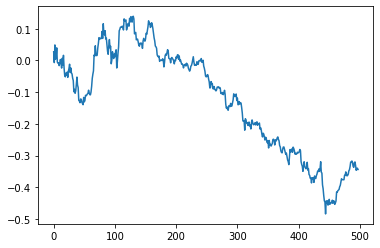

In [449]:
closing_array = closing_returns.to_numpy()
market_array = market_returns.to_numpy()

excess_returns_plugin = []


for i in range(len(closing_prices) - 122):
    baseline = np.mean(market_array[i:i+120,])
    y = closing_array[i:i+120,]
    mu = np.mean(y, axis=0)
    sigma = np.cov(y.T)
    
    w = get_w(mu, sigma, baseline)
    
    
    next_return = closing_array[i+121]@w
    excess_returns_plugin.append((next_return - market_array[i+121])[0])
    
    

plt.plot(np.cumsum(excess_returns_plugin))    


# NPEB

We use an autoregressive factor model and a garch model to preform the NPEB method. To optimize for eta and the best information ratio we additionally use bootstraping. 

/Users/amansawhney/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


/Users/amansawhney/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


/Users/amansawhney/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


/Users/amansawhney/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


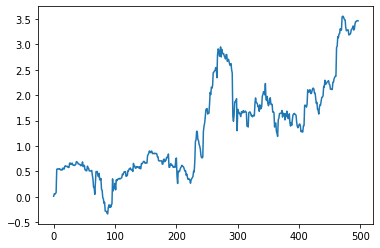

In [470]:
closing_array = closing_returns.to_numpy()
market_array = market_returns.to_numpy()

excess_returns_NPEB = []

for idx in range(1, len(closing_prices) - 122):
    baseline = np.mean(market)
    shifted_y = closing_array[idx - 1:idx + 119,]
    y = closing_array[idx:idx+120,]
    market = market_array[idx:idx+120,]
    X = np.c_[market.reshape(-1,1), shifted_y]
    reg = LinearRegression().fit(X, y)
    B = reg.coef_
    mu = (X@(B.T))
    mu_n = mu[-1]
    V_n = (mu_n.reshape(y.shape[1], -1))@(mu_n.reshape(y.shape[1], -1)).T    
    res = (y - reg.predict(X))
    z = []
    s = []
    
    for i in range(y.shape[1]):
        stock_res = res[:,i]
        model = arch_model(stock_res, vol="GARCH", p=1, q=1, rescale=False)
        fitted_model = model.fit(disp="off")
        s.append(fitted_model.conditional_volatility[-1])
        z.append(fitted_model.resid/fitted_model.conditional_volatility)
        
    z = np.array(z)
    sigma = np.cov(z)
        
    for i in range(y.shape[1]):
        for j in range(y.shape[1]):
            V_n[i][j] += s[i]*s[j]*sigma[i][j]
            
            
    one_matrix = np.ones((V_n.shape[0],))
            
    A = (mu_n.T @ np.linalg.inv(V_n) @ one_matrix)
    B = (mu_n.T @ np.linalg.inv(V_n) @ mu_n)
    C = (one_matrix.T @ np.linalg.inv(V_n) @ one_matrix)
    
    
    
    best_ratio = -np.inf
    w_final = None
    
                
    for j in range(-2, 2):
        lam = 2**j
        
        def c_eta(x):
            w = (np.linalg.inv(V_n)@ one_matrix)/(C) + x/(2*lam)*np.linalg.inv(V_n)@(mu_n - A/C*one_matrix)
            bootstrapped_returns = y[np.random.randint(y.shape[0], size=10000), :]
            return -1*(np.mean(bootstrapped_returns@w) - lam*np.var(bootstrapped_returns@w))
                    
        res = minimize_scalar(c_eta)
        eta = res.x
        w = (np.linalg.inv(V_n)@ one_matrix)/(C) + eta/(2*lam)*np.linalg.inv(V_n)@(mu_n - A/C*one_matrix)
        bootstrapped_returns = y[np.random.randint(y.shape[0], size=10000), :]
        returns = bootstrapped_returns@w
        info_ratio = np.mean(returns - baseline)/np.std(returns - baseline)
        if info_ratio > best_ratio:
            best_ratio = info_ratio
            w_final = w
            
    next_return = closing_array[idx+121]@w_final
    excess_returns_NPEB.append((next_return - market_array[idx+121])[0])
    print(idx, next_return,  market_array[idx+121], np.sum(excess_returns_NPEB), end="\r")
    



    
plt.plot(np.cumsum(excess_returns_NPEB))    

# rolling_df = closing_prices.rolling(window=120)
# for slide in rolling_df:
#     print(slide)
#     y = slide.to_numpy()
#     print(y)
#     X = np.array([i for i in range(120)]).reshape(-1,1)
#     reg = LinearRegression().fit(X, y)
#     B = reg.coef_
#     mu = B.T@X
#     print(mu)

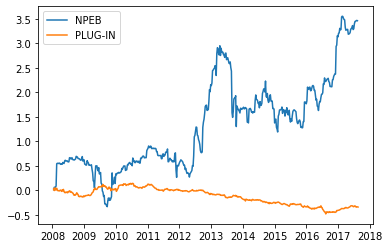

In [486]:
plt.plot(dates[0:-121], np.cumsum(excess_returns_NPEB), label = "NPEB")    
plt.plot(dates[0:-120],np.cumsum(excess_returns_plugin), label = "PLUG-IN")
plt.legend()
plt.show()

